<center><h1>Patel_Datt_Project</h1></center>

Name: Datt Patel 
<br>
Github Username: dattpatel99
<br>
USC ID: 2149812400

In [2]:
import os
import cv2
import pathlib
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### Define Constants

In [4]:
IMG_WID, IMG_HG = 224, 224
IMG_SIZE = (IMG_WID, IMG_HG)
VAL_RATIO = 0.15
TEST_RATIO = 1
TRAIN_RATIO = 0.7
PATIENCE = 2
BATCH_FIT = 128
EPOCHS = 50

In [5]:
data_files = '../data'
data_locs = [data_files+'/Sport Images', data_files+'/Sport Videos']

In [6]:
# Print tf.data.dataset image
def showIMG(tf_dataset):
    for images, label in tf_dataset.take(1):
        plt.imshow(images.numpy())
        plt.axis("off")

### Reading Images into Datasets

In [7]:
def createFileDataset(filePath, label):
    # Read files as tf.data.dataset objects
    file_data = tf.keras.utils.image_dataset_from_directory(filePath,
                                                          labels=None,
                                                          label_mode='int',
                                                          color_mode='rgb',
                                                          batch_size=None,
                                                          image_size=IMG_SIZE,
                                                          seed=99)
    # Create tuple of label and dataset
    file_data = file_data.map(lambda x: (x, label))
    # Split data into different sections based on their ratio
    # Find number of images in each section
    num_images = len(file_data)
    train_images = int(np.ceil(num_images*TRAIN_RATIO)) 
    val_images = int(np.ceil(num_images*VAL_RATIO))
    test_images = int(TEST_RATIO*(num_images - (train_images + val_images)))
    # Split the dataset 
    train_data = file_data.take(train_images)
    val_data = file_data.skip(train_images).take(val_images)
    test_data = file_data.skip(train_images + val_images).take(test_images)
    return [train_data, val_data, test_data]

In [8]:
classes = ['baseball','basketball','fencing','tennis','volleyball']
image_data = []
for idx in range(len(classes)):
    image_data.append(createFileDataset(data_locs[0]+'/'+classes[idx], idx))

Found 734 files belonging to 1 classes.
Found 492 files belonging to 1 classes.
Found 634 files belonging to 1 classes.
Found 715 files belonging to 1 classes.
Found 704 files belonging to 1 classes.


In [9]:
train = image_data[0][0]
val = image_data[0][1]
test = image_data[0][2]
for data_train, data_val, data_test in image_data[1:]: 
    train = train.concatenate(data_train)
    val = val.concatenate(data_val)
    test = test.concatenate(data_test)

### Image Augmentation

In [10]:
flip_img = tf.keras.layers.RandomFlip("horizontal_and_vertical")
rot_img = tf.keras.layers.RandomRotation((-0.2, 0.5))
trans_img = tf.keras.layers.RandomTranslation((-0.2, 0.5), (-0.2, 0.5))
zoom_img = tf.keras.layers.RandomZoom((-0.1, 0.3))
brightness_img = tf.keras.layers.RandomBrightness(0.4)
contrast_img = tf.keras.layers.RandomContrast(0.6)

In [11]:
def chooseRandom(x):
    chooser = np.random.randint(0,1)
    # Randomly choose which type of augmentation to do but first one gets a little more edge
    if chooser >= 0.6:
        return trans_img(flip_img(contrast_img(zoom_img(x))))
    else:
        return rot_img(brightness_img(x))

In [12]:
# DO augmentation on training data
augmented_data = train.map(lambda x,y:(chooseRandom(x), y))
flip_dataset = train.map(lambda x,y:(flip_img(x), y))
rot_dataset = train.map(lambda x,y:(rot_img(x), y))
trans_dataset = train.map(lambda x,y:(trans_img(x), y))
zoom_dataset = train.map(lambda x,y:(zoom_img(x), y))

In [13]:
train_new = train.concatenate(augmented_data)
train_new = train_new.concatenate(flip_dataset)
train_new = train_new.concatenate(rot_dataset)
train_new = train_new.concatenate(trans_dataset)
train_new = train_new.concatenate(zoom_dataset)

In [14]:
batched_train = train_new.batch(128, drop_remainder=True)
batched_val = val.batch(128, drop_remainder=True)
batched_test = test.batch(128, drop_remainder=True)

### Create models: ResNet50, EfficientNetB0, VGG16

In [15]:
def createModel(base_model):
    for layer in base_model.layers:
        layer.trainable = False
    model_run = tf.keras.layers.Flatten()(base_model.output)
    model_run = tf.keras.layers.Dense(32, activation='relu')(model_run)
    model_run = tf.keras.layers.Dropout(0.2)(model_run)
    model_run = tf.keras.layers.BatchNormalization()(model_run)
    model_run_predictions = tf.keras.layers.Dense(5, activation = 'softmax')(model_run)
    model_head = tf.keras.Model(inputs = base_model.input, outputs = model_run_predictions)
    model_head.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model_head

In [16]:
resnet_base = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (IMG_WID, IMG_HG, 3))
efficient_base = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (IMG_WID, IMG_HG, 3))
vgg_base = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMG_WID, IMG_HG, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [17]:
resnet_head = createModel(resnet_base)
efficient_head = createModel(efficient_base)
vgg_head = createModel(vgg_base)

In [18]:
# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, mode='min', restore_best_weights=True) # Early stop and restore weight from best model

#### Training models

In [19]:
resnet_history = resnet_head.fit(batched_train, epochs=EPOCHS, batch_size=BATCH_FIT, callbacks=[early_stop], verbose=1, validation_data=batched_val)

Epoch 1/50
107/107 [==============================] - 336s 3s/step - loss: 1.7807 - accuracy: 0.2178 - val_loss: 1.3770 - val_accuracy: 0.6068
Epoch 2/50
107/107 [==============================] - 108s 1s/step - loss: 1.6541 - accuracy: 0.2404 - val_loss: 1.1758 - val_accuracy: 0.7917
Epoch 3/50
107/107 [==============================] - 107s 997ms/step - loss: 1.6229 - accuracy: 0.2691 - val_loss: 1.1322 - val_accuracy: 0.8750
Epoch 4/50
107/107 [==============================] - 107s 1s/step - loss: 1.6068 - accuracy: 0.2780 - val_loss: 1.2552 - val_accuracy: 0.8802
Epoch 5/50
107/107 [==============================] - 107s 993ms/step - loss: 1.5960 - accuracy: 0.2978 - val_loss: 1.3718 - val_accuracy: 0.9089
Epoch 5: early stopping


In [21]:
efficient_history = efficient_head.fit(batched_train, epochs=EPOCHS, batch_size=BATCH_FIT, callbacks=[early_stop], verbose=1, validation_data=batched_val)

Epoch 1/50
107/107 [==============================] - 99s 866ms/step - loss: 1.8432 - accuracy: 0.2316 - val_loss: 0.8177 - val_accuracy: 0.7969
Epoch 2/50
107/107 [==============================] - 91s 850ms/step - loss: 1.6813 - accuracy: 0.2789 - val_loss: 0.8642 - val_accuracy: 0.9323
Epoch 3/50
107/107 [==============================] - 89s 828ms/step - loss: 1.6337 - accuracy: 0.3025 - val_loss: 0.8856 - val_accuracy: 0.9531
Epoch 3: early stopping


In [22]:
vgg_history = vgg_head.fit(batched_train, epochs=EPOCHS, batch_size=BATCH_FIT, callbacks=[early_stop], verbose=1, validation_data=batched_val)

Epoch 1/50
107/107 [==============================] - 146s 1s/step - loss: 1.7538 - accuracy: 0.2035 - val_loss: 1.3648 - val_accuracy: 0.5182
Epoch 2/50
107/107 [==============================] - 129s 1s/step - loss: 1.6575 - accuracy: 0.2286 - val_loss: 1.3800 - val_accuracy: 0.7214
Epoch 3/50
107/107 [==============================] - 128s 1s/step - loss: 1.6316 - accuracy: 0.2439 - val_loss: 1.4888 - val_accuracy: 0.7292
Epoch 3: early stopping


### Model Evaluation

In [24]:
# Plotting function for showing Model Loss per Epoch
def plotLossEpoch(model_history, model):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('{} Model Loss'.format(model))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

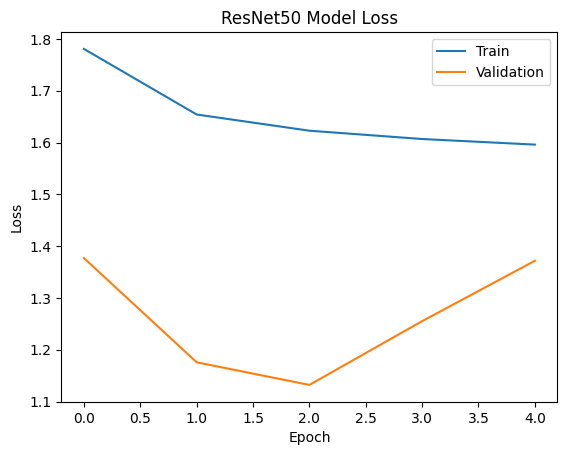

In [25]:
plotLossEpoch(resnet_history, 'ResNet50')

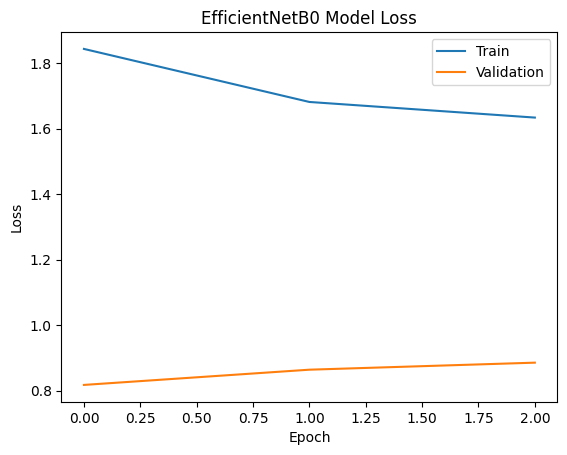

In [26]:
plotLossEpoch(efficient_history, 'EfficientNetB0')

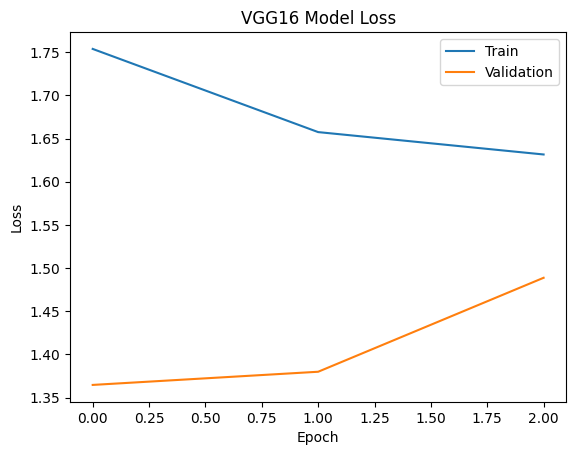

In [27]:
plotLossEpoch(vgg_history, 'VGG16')

### Predictions

#### Train

In [28]:
train_resnet_pred = resnet_head.predict(batched_train)
train_efficient_pred = efficient_head.predict(batched_train)
train_vgg_pred = vgg_head.predict(batched_train)

107/107 [==============================] - 121s 1s/step


#### Test

In [29]:
resnet_pred = resnet_head.predict(batched_test)
efficient_pred = efficient_head.predict(batched_test)
vgg_pred = vgg_head.predict(batched_test)

3/3 [==============================] - 4s 1s/step


#### Train

In [31]:
train_resnet_pred = np.argmax(train_resnet_pred, axis=1)
train_efficient_pred = np.argmax(train_efficient_pred, axis=1)
train_vgg_pred = np.argmax(train_vgg_pred, axis=1)

#### Test

In [30]:
resnet_pred = np.argmax(resnet_pred, axis=1)
efficient_pred = np.argmax(efficient_pred, axis=1)
vgg_pred = np.argmax(vgg_pred, axis=1)

### Statistical Analysis of Image Models

Methods for claculating Precision, Recall, Accuracy, F1 and Confusion Matrix itesm for multiclassification are from

https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification

In [32]:
# ACCURACY
def findaccuracy(y_true, y_pred):
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0    
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:            
            correct_predictions += 1
    return correct_predictions / len(y_true)

In [33]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives
def true_positive(y_true, y_pred):
    tp = 0
    for yt, yp in zip(y_true, y_pred):        
        if yt == 1 and yp == 1:
            tp += 1
    return tp

def true_negative(y_true, y_pred):    
    tn = 0
    for yt, yp in zip(y_true, y_pred):        
        if yt == 0 and yp == 0:
            tn += 1
    return tn

def false_positive(y_true, y_pred):    
    fp = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 0 and yp == 1:
            fp += 1            
    return fp

def false_negative(y_true, y_pred):
    fn = 0    
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:
            fn += 1            
    return fn

# PRECISION
def macro_precision(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize precision to 0
    precision = 0
    # loop over all classes
    for class_ in np.unique(y_true):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
    # calculate and return average precision over all classes
    precision /= num_classes
    return precision

In [34]:
# RECALL
def macro_recall(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize recall to 0
    recall = 0
    # loop over all classes
    for class_ in np.unique(y_true):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        # keep adding recall for all classes
        recall += temp_recall
    # calculate and return average recall over all classes
    recall /= num_classes
    return recall

In [35]:
# F1
def macro_f1(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize f1 to 0
    f1 = 0
    # loop over all classes
    for class_ in np.unique(y_true):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        temp_f1 = 2 * temp_precision * temp_recall / (temp_precision + temp_recall + 1e-6)
        # keep adding f1 score for all classes
        f1 += temp_f1
    # calculate and return average f1 score over all classes
    f1 /= num_classes
    return f1

In [36]:
# Statistics of model prediction
def displayAnalysis(model_name, y_test, y_pred):
    print("Results for model {}".format(model_name))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    precision = macro_precision(y_test, y_pred)
    recall = macro_recall(y_test, y_pred)
    accuracy = findaccuracy(y_test, y_pred)
    f1 = macro_f1(y_test, y_pred)

    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

In [37]:
# Combine the batches into single array 
test_label = []
for img, label in (batched_test.take(len(batched_test))):
    test_label += list(label.numpy())
test_label = np.array(test_label)

In [38]:
# Combine the batches into single array 
train_label = []
for img, label in (batched_train.take(len(batched_train))):
    train_label += list(label.numpy())
train_label = np.array(train_label)

#### Train 

In [39]:
displayAnalysis('ResNet', train_label, train_resnet_pred)

Results for model ResNet
Confusion Matrix:
 [[2234  124  193  147  386]
 [  22 1732   21   41  254]
 [  76   22 1937   31  598]
 [ 667  156  159 1522  502]
 [  31  271  100    8 2462]]
Precision: 0.7497122332320477
Recall: 0.7303528050683574
Accuracy: 0.7218896028037384
F1 Score: 0.7244578703487774


In [40]:
displayAnalysis('EfficientB0', train_label, train_efficient_pred)

Results for model EfficientB0
Confusion Matrix:
 [[2667   19  131  179   88]
 [ 132 1577   36   47  278]
 [ 281   10 2031  120  222]
 [1058   56  149 1601  142]
 [ 135  250  113   76 2298]]
Precision: 0.764973577734589
Recall: 0.7443499733024708
Accuracy: 0.7428446261682243
F1 Score: 0.745103161071335


In [41]:
displayAnalysis('VGG16', train_label, train_vgg_pred)

Results for model VGG16
Confusion Matrix:
 [[ 606   80  432 1316  650]
 [  24  390   30  606 1020]
 [  88    6 1539  317  714]
 [  79   52  226 2226  423]
 [   8   27  204  156 2477]]
Precision: 0.6078116223410767
Recall: 0.5131181392989936
Accuracy: 0.5284754672897196
F1 Score: 0.4808064051761023


#### Test

In [42]:
displayAnalysis('ResNet50', test_label, resnet_pred)

Results for model ResNet50
Confusion Matrix:
 [[92  4  9  3  1]
 [ 2 67  1  1  2]
 [ 2  0 86  2  4]
 [29  2  5 62  8]
 [ 0  0  0  0  2]]
Precision: 0.7069410170357672
Recall: 0.8523287316515228
Accuracy: 0.8046875
F1 Score: 0.7018704122554646


In [43]:
displayAnalysis('EfficientNetB0', test_label, efficient_pred)

Results for model EfficientNetB0
Confusion Matrix:
 [[103   0   1   4   1]
 [  7  62   1   1   2]
 [ 10   0  74   7   3]
 [ 36   1   5  62   2]
 [  0   1   0   0   1]]
Precision: 0.698307110360646
Recall: 0.7332817231335256
Accuracy: 0.7864583333333334
F1 Score: 0.6797774011018654


In [44]:
displayAnalysis('VGG16', test_label, vgg_pred)

Results for model VGG16
Confusion Matrix:
 [[28  2 19 45 15]
 [ 1 17  0 28 27]
 [ 0  0 72 13  9]
 [ 1  0  6 94  5]
 [ 0  0  1  0  1]]
Precision: 0.6205060091905088
Recall: 0.52850141477026
Accuracy: 0.5520833333333334
F1 Score: 0.44273643044636596


Conclusion:
Resnet model performs the best on the test set while the Efficient isn't too far behind, VGG could still perform better. Running for larger number of epochs and more patience would give better results.

### Frame by Frame Analysis

#### Retrain best model

In [45]:
'''
Due to lack of time I could only retrain the model that I was going to use to predict.
'''
vide_resnet_history = resnet_head.fit(batched_val, epochs=EPOCHS, batch_size=BATCH_FIT, callbacks=[early_stop], verbose=1, validation_data=batched_test)

Epoch 1/50
3/3 [==============================] - 10s 3s/step - loss: 1.4030 - accuracy: 0.4714 - val_loss: 1.1644 - val_accuracy: 0.8490
Epoch 2/50
3/3 [==============================] - 9s 3s/step - loss: 1.3517 - accuracy: 0.4583 - val_loss: 1.0912 - val_accuracy: 0.8542
Epoch 3/50
3/3 [==============================] - 9s 4s/step - loss: 1.3621 - accuracy: 0.5026 - val_loss: 1.2733 - val_accuracy: 0.8802
Epoch 4/50
3/3 [==============================] - 11s 4s/step - loss: 1.3207 - accuracy: 0.5417 - val_loss: 1.0346 - val_accuracy: 0.8646
Epoch 5/50
3/3 [==============================] - 10s 4s/step - loss: 1.2839 - accuracy: 0.5547 - val_loss: 0.9944 - val_accuracy: 0.8620
Epoch 6/50
3/3 [==============================] - 11s 4s/step - loss: 1.2886 - accuracy: 0.5234 - val_loss: 0.9854 - val_accuracy: 0.8411
Epoch 7/50
3/3 [==============================] - 9s 4s/step - loss: 1.2281 - accuracy: 0.5443 - val_loss: 0.8691 - val_accuracy: 0.8906
Epoch 8/50
3/3 [=====================

### Statistical Analysis of Video

In [46]:
L = 100 # minimum number of frames from video if it has a length equal or more to it

# Alter frame dimensions to be useful
def preprocess_frame(frame_img):
    frame_img = cv2.resize(frame_img, (IMG_WID, IMG_HG))
    frame_img = np.expand_dims(frame_img, axis=0)
    return frame_img

In [50]:
# Get all file paths for videos and their labels
def getFilesandLabels():
    video_dir = pathlib.Path('/content/drive/Shareddrives/552 Project/Final Project/data/Sport Videos')
    paths = []
    vid_true = []
    class_mappings = {'BaseballPitch':0,'Basketball':1,'Fencing':2,'TennisSwing':3,'VolleyballSpiking':4}
    for vid_path in video_dir.glob('**/*.avi'):
        cur_class = os.path.basename(os.path.dirname(vid_path)).split('/')[-1]
        vid_true.append(class_mappings[cur_class])
        paths.append(str(vid_path))
    return paths, vid_true

# Prediction
def getVideoTestSet(vid_path):
    resnet_pred = []
    # Verify file type
    if str(vid_path)[-4:] == '.avi':
        extracted_frames =[]
        cap = cv2.VideoCapture(str(vid_path))
        length_vid = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        #Fun Fact: grab and retrieve has better time complexity then other methods https://vuamitom.github.io/2019/12/13/fast-iterate-through-video-frames.html
        success = cap.grab() # Check if there is a frame to get
        while success:
            if (len(extracted_frames) < int(L) or (len(extracted_frames)/length_vid) < 0.6):
                success, img = cap.retrieve() # Retrieve frame
                frame = preprocess_frame(img)
                resnet_pred.append(resnet_head.predict(frame, verbose=0))
                success = cap.grab()
        cap.release()
    tf.keras.backend.clear_session()
    return np.argmax(np.mean(resnet_pred, axis=0)) 

In [51]:
paths, y_labels = getFilesandLabels()
dataset = list(map(getVideoTestSet, tqdm(paths)))

100%|██████████| 681/681 [1:39:24<00:00,  8.76s/it]


In [52]:
dataset # Prediction output

[2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 3,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 4,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,


In [53]:
displayAnalysis('ResNet50', y_labels, dataset) 

Results for model ResNet50
Confusion Matrix:
 [[131   0  19   0   0]
 [ 65   0  69   2   1]
 [  8   0 102   0   1]
 [150   0  17   0   0]
 [ 14   0 102   0   0]]
Precision: 0.13721506924251967
Recall: 0.35845044763029627
Accuracy: 0.342143906020558
F1 Score: 0.19830099738404283


Based on the results we see that the model is able to predict videos to be majorly of 2 classes 0 and 2. This could be mainly because of the low patience I used to train the model. Using more epochs and more patience could give us better results

### References

https://pyimagesearch.com/2021/06/28/data-augmentation-with-tf-data-and-tensorflow/

https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

https://www.datacamp.com/tutorial/complete-guide-data-augmentation

https://www.tensorflow.org/tutorials/load_data/images

https://vuamitom.github.io/2019/12/13/fast-iterate-through-video-frames.html

https://www.freecodecamp.org/news/improve-image-recognition-model-accuracy-with-these-hacks/

https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification

https://www.youtube.com/watch?v=mTVf7BN7S8w&ab_channel=codebasics

https://www.youtube.com/watch?v=ccdssX4rIh8&t=1038s&ab_channel=DigitalSreeni

https://www.youtube.com/watch?v=jztwpsIzEGc&t=2500s&ab_channel=NicholasRenotte